# MSE 446 Project Report
Group 19  
Lucy He, Junshi Li, Jason Liu, Carrick Shi


## Introduction and Problem Statement
Recent catastrophic wildfires highlight the growing threat of natural disasters. In July 2018, a wildfire ignited in Greece and rapidly spread across the region [1]. As of September 2020, wildfires in California had burned over 1.5 million hectares, affecting approximately 3.7% of the state's total area [2]. In January 2025, Los Angeles faced unprecedented winter wildfires, causing 29 fatalities and destroying over 16,000 structures [3]. In 2023, Alberta had 36 severe fires burning 2.2 million hectares—far exceeding the five-year average of 169,556 hectares [4]. These events emphasize the urgent need for accurate wildfire prediction models to mitigate future risks. 
  
Wildfires have significant impacts on social structures, disrupt wildlife activities, and pose substantial economic challenges to cities. Consequently, the development of accurate and effective wildfire prediction methods is essential for mitigating these adverse effects. The goal of this project is to predict wildfire occurrence probabilities based on data including fire data, weather data, lightning occurrence and population density. According to Natural Resources Canada, Alberta has the highest Fire Weather Index (FWI) values in Canada due to frequent summer wildfires, large forested areas, and dry climate conditions. Given Alberta's high wildfire activity, this study focuses on the region to develop targeted mitigation strategies. In this project, three Machine Learning models are proposed, developed, and evaluated, including Logistic Regression, Decision Tree, and Fully Connected Neural Network, aimed at predicting wildfire occurrences and facilitating early intervention to prevent their spread. Using k-fold cross-validation, these models will be evaluated based on a fraction of correct predictions and root mean square (RMS) error metrics to assess their effectiveness for wildfire forecasting. 

#### Research on Wildfire Prediction

There has been ongoing research about wildfire predictions, and we observed a lot of excellent work; for example, we noticed Sanabria et al.’s interpolation-based study of fire danger indices across Australia [5]. Our approach and the work by Sanabria et al.. aim to improve the understanding of wildfire risk through historical weather conditions. Essentially, both approaches used data such as temperature, humidity, wind speed, rainfall, and vegetation conditions to assess fire danger at various locations during the year. This foundation highlights a shared objective of extracting environmental patterns as fire risk indicators.

Another research is written by Shadrin et al., they utilized a neural network algorithm based on the MA-Net architecture for predicting fire spread up to 5 days in advance [6]. The model achieved an F1-score of 0.67 during testing over three days [6], indicating a reasonable level of accuracy for fire prediction.

G. Bayat and K. Yıldız proved that the use of multiple models allows for a comprehensive analysis of prediction capabilities [7]. The article introduced models such as Multilayer Perceptron (MLP), Linear Regression, Support Vector Machine (SVM), K-Nearest Neighbors (KNN), Decision Tree, and Stacking methods. It concludes that the SVM model achieved the best predictive ability with a Mean Absolute Error (MAE) of 12.8879. MLP had the worst performance with an MAE of 38.7481, indicating lower accuracy [7].



## Data Sources and Feature Selection

The purpose of this project is to build a machine learning model for predicting the occurrence of wildfires in Alberta by integrating multiple environmental and human factors related data. In order to achieve effective modeling and assessment of wildfire events, we collected and processed multiple data sources, including information on historical wildfire records, meteorological data, lightning activity, and population density. Each dataset reveals different perspectives on the potential drivers of wildfire occurrence and spread, allowing us to construct a complete feature set that encompasses both fire and non-fire scenarios. Our data preprocessing process works to standardize these differently structured data, unifying feature extraction in both spatial and temporal dimensions to provide consistent support for model training. This section details the four main categories of data sources we use and describes the methods and strategies we employ in the data enhancement and integration process.

#### Fire Data

The first data source comes from the historical wildfire data from the Government of Alberta, which is available from the Government of Alberta. This dataset contains over 26000 records of wildfires between 2006 and 2024, each entry includes the wildfire’s time of occurrence, geographic location in terms of latitude and longitude, and additional information about the fire, such as cause of fire, fuel type (vegetation type in that area), and local weather conditions at the time of fire. Next, we need to process the raw dataset into a format we can train our models with. To incorporate negative (non-fire) examples for training our model, we use the latitude and longitude coordinates from the wildfire dataset as reference points. We round these coordinates to one decimal place and group fires that occurred within the same rounded location. For each such location, we randomly generate additional timestamps spanning 2006 to 2024 that are not associated with recorded wildfires, such that in total, each location will have at least 10 entries of fire and non-fire date times, and these synthesized entries represent non-fire conditions. We assume that the location’s fuel type doesn’t significantly change over time, and then assign that fuel type to the generated non-fire data entries. These new data entries will be uniquely identified by their longitude, latitude, and timestamp. From this dataset, we extract the fuel type as a static environmental feature, and define a binary classifier label indicating fire occurrence (Fire = True/False). We do not use the weather data provided in this dataset, as it lacks coverage for non-fire events and may introduce inconsistency. Instead, we source weather information separately to maintain uniformity across both fire and non-fire instances (see Weather Dataset section).


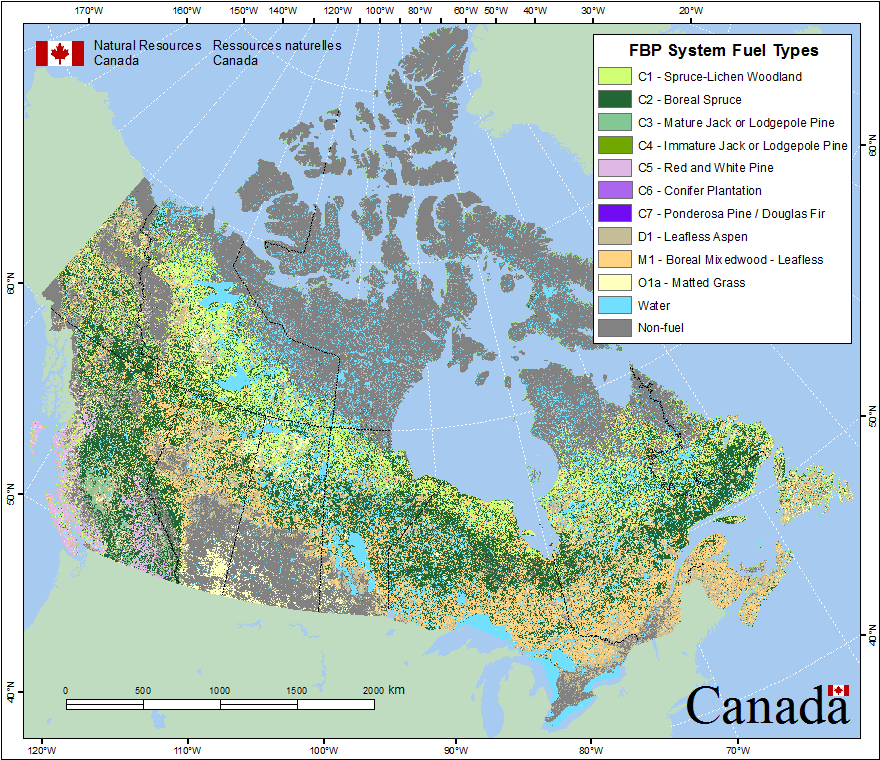
[8]

#### Weather Data: Temperature, Humidity, Wind, Rainfall

The second data source comes from over 600 weather stations located all across Alberta, from which we extracted daily weather data from each station between 2006-2024. Inside the dataset, there are a total of 31 weather parameters, but we’re only interested in some of the important ones which we believe are closely related to wildfires: 
- Max/Min/Mean Temperature (°C): High temperatures dry out vegetation, increasing flammability.
- Total Precip (mm): Low rainfall increases the dryness of plants, which also increases fire probability
- Speed of Max Gust (km/h, 10s deg): Strong winds accelerate fire spread
- Spatial feature (Longitude, Latitude): Some regions are more fire-prone due to different topography at different locations (ex., wildfires are less likely to occur in places with less vegetation)

For each fire and non-fire entry in the previous dataset, we map the location and timestamp to the nearest available weather station by first rounding the timestamp in the wildfire dataset to the nearest day. From the subset of stations that contain valid data for that day, we identify the closest station geographically to provide the associated weather data.
Due to inconsistencies in data availability, such as missing weather conditions in some of the stations from 2006-2024, we need to filter the dataset to extract usable entries. After filtering, we obtain <mark>####</mark> data points in total, of which <mark>####</mark> correspond to true wildfire events. 
We also used another source of weather data: OpenWeather API. This API allows us to retrieve historical hourly weather data for specific latitudes, longitudes, and timestamp combinations, accurate to the hour, to obtain consistent and detailed weather information for both wildfire and non-wildfire events at designated locations. But since this API only allows us to retrieve weather data in 2024, we would need to slice our wildfires and weather station datasets for 2024 only.

The two weather data sources used in our project (weather station data and OpenWeather API) each offer distinct advantages and limitations, leading to a trade-off between spatial accuracy and temporal coverage. The OpenWeather API offers highly localized and consistent weather features across both fire and non-fire cases, however, its limitation is that it only provides data for the year 2024, which limits the size and diversity of our training dataset, since measuring wildfires in a single year is subject to bias due to unique weather patterns.

In contrast, data from the Government of Alberta’s weather station spans a much longer period (2006–2024), allowing us to build a larger and more temporally diverse dataset. However, this way we would need to sacrifice spatial resolution, as it only records weather at fixed station locations. Based on a histogram of nearest-station distances, we selected a 50 km maximum distance threshold to limit location mismatch, but it still introduces an unavoidable approximation. Another limiting factor of using this dataset is that there are missing values and important weather parameters in weather stations, which affect the overall data quality.



#### Lightning Occurence

We obtained the total lighting occurrences of 15 different cities in Alberta from 1999-2018, according to the Government of Canada. Lightning caused almost 47% of the total wildfires around Alberta in 2024, and thus it would be necessary to include lightning as a feature of the model when we’re predicting the probability of fire. However, since we only have the total number of lightning strikes of a city over ~20 years, and our previous datasets all have specific spatial features in longitude and latitude, we assigned a “lightning index” to every spatial coordinate in the dataset to incorporate the idea of the probability of getting lightning strikes at that place: 

given a coordinate in the dataset, we first calculate the distance between the location and the 5 closest cities around it, 

$$
R_1, R_2, \dots, R_{5},
$$


then, given the number of total lightning strikes in the 5 cities, 

$$
a_1, a_2, \dots, a_{5},
$$


we use that number and divide by the square of the distance calculated before, and we add them together to obtain the “lightning index” of any location. In this way, we approximated the probability of getting lightning strikes at any location in Alberta.

$$
\frac{a_1}{R_1^2}, \frac{a_2}{R_2^2}, \dots, \frac{a_{5}}{R_{5}^2}
$$

#### Population Density

The last dataset we obtained is the population density dataset. According to the Government of Alberta, 50% of total wildfires were human-caused in 2024, we noticed there’s a strong correlation between human activities and wildfires, and thus we believe population density of a place also plays an important role in creating wildfires. As a result, we obtained the population density of a total of 119 places in 2021, and we filtered out the following 3 specs: {population density per square kilometre, total private dwellings, geographic area type}. For any given location in the previous dataset, we find the 1 out of 119 places that is closest to the location and append its 3 features to that location.

### Data Preprocessing

## Methodology
<font color='red'>You should focus less on introducing the algorithms and more introducing your problem, data and how/why you use certain algorithms. </font>

### 1. Logistic Regression

This project chose to use Logistic Regression because of its effectiveness in binary classification tasks. In the project, the model will distinguish between fire and non-fire conditions based on environmental features such as temperature, humidity, wind speed, and weather conditions.
Logistic regression is suitable for predicting wildfires because it is interpretable, efficient and predictive. The first advantage is the ability to analyze how each feature affects the probability of a wildfire occurring through the learned data. This interpretability helps understand which environmental factors have the greatest impact on fire risk. In addition, logistic regression is computationally efficient, which allows it to handle datasets of various specifications. A final advantage is its ability to generate estimated probabilities, not just binary classifications, which will visualize the results. In the end, logistic regression is less prone to overfitting than more complex models. This allows the model to make relatively accurate predictions not only on training sets, but also on real-world data.
The implementation of the logistic regression model followed a structured set of methods that would ensure its effectiveness in predicting wildfire. First, wildfire occurrence data is collected and preprocessed to ensure the dataset includes essential environmental factors for accurate fire risk assessment. After data preparation, the dataset is divided into an 80% training set and a 20% test set. This division of the data allows the model to learn from the majority of the data, while keeping a separate test set for evaluating the model's performance. ​
After data preparation, model training was started. The logistic regression model was initialized and the maximum number of iterations was set to 1000 to ensure proper convergence during optimization. The model was then trained using the training dataset to allow it to learn the relationship between input environmental factors and wildfire occurrence. Once training was completed, multiple evaluation metrics were used to measure the effectiveness of the model.
####  How to Evaluation
The construction of the logistic regression model forms a solid benchmark for wildfire prediction. Although the model is highly interpretable and computationally efficient, it still has limitations in capturing complex nonlinear relationships in the dataset. Therefore, future research will explore more advanced models, such as Decision Trees and Neural Networks, to further improve prediction accuracy and enhance the effectiveness of wildfire prevention strategies.


### 2. Decision Tree Classifiers

Decision tree models were chosen as the second model because of their ability to capture nonlinear relationships and provide a rule-based classification structure. Decision trees will model interactions between variables, this makes them suitable for environmental datasets where interactions are probably not direct.
Decision trees are highly interpretable because they represent decisions in a tree graph of rules, and they are easy to follow. Each internal node of the tree corresponds to a type of decision based on features, and each leaf node corresponds to the class label of the prediction. This feature allows stakeholders to easily understand how to make predictions. In addition, decision trees are able to handle missing values, which is advantageous when dealing with wildfire data that may be noisy.
The implementation of the decision tree model is based on the DecisionTreeClassifier in the sklearn library.The minimum number of split samples is set to 100 when the model is initialized to prevent overfitting phenomenon from occurring and to ensure that the amount of data is large enough for each split. During the model construction, environmental factors were selected as input features, including temperature, humidity, wind speed and weather conditions. These features were used to train the model to learn its relationship with wildfire occurrence.
#### How to Evaluation
In terms of model evaluation, the decision tree structure obtained from training is displayed in the form of graphs, which makes the prediction logic of the model easier to understand and interpret. In addition, the model's classification effectiveness was comprehensively evaluated by generating confusion matrices, classification reports, and accuracy metrics. In conclusion, the decision tree model provides an alternative perspective on the wildfire prediction problem, especially in application scenarios that require strong interpretability and capture nonlinear relationships.


### 3. Fully Connected Neural Network (FCNN)




## Results & Analysis

## Conclusion & Future Work

## References

[1] Lagouvardos, K., Kotroni, V., Giannaros, T. M. & Dafis, S. Meteorological Conditions Conducive to the Rapid Spread of the Deadly Wildfire in Eastern Attica, Greece. Bull. Am. Meteorological Soc. 100, 2137–2145 (2019). Publisher: American Meteorological Society Section: Bulletin of the American Meteorological Society.

[2] Higuera, P. E. & Abatzoglou, J. T. Record-setting climate enabled the extraordinary 2020 fire season in the western United States. Glob. Change Biol. 27, 1–2 (2021).

[3] A. School, “Economic Impact of the Los Angeles Wildfires,” UCLA Anderson School of Management, Jan. 31, 2025. https://www.anderson.ucla.edu/about/centers/ucla-anderson-forecast/economic-impact-los-angeles-wildfires

[4] Government of Alberta, “2023 Alberta Wildfire’s seasonal statistics,” Dec. 2023.

[5] Sanabria L.A., Qin X., Li J., Cechet R.P., and Lucas C. 2013. Spatial interpolation of McArthur’s Forest Fire Danger Index across Australia: observational study. Environ. Model. Softw. 50: 37–50.

[6] Shadrin, D., Illarionova, S., Gubanov, F. et al. Wildfire spreading prediction using multimodal data and deep neural network approach. Sci Rep 14, 2606 (2024). https://doi.org/10.1038/s41598-024-52821-x

[7] G. Bayat and K. Yıldız, “Comparison of the Machine Learning Methods to Predict Wildfire Areas”, TJST, vol. 17, no. 2, pp. 241–250, 2022, doi: 10.55525/tjst.1063284.

[8] N. R. Canada, “Canadian Wildland Fire Information System | Background Maps,” Nrcan.gc.ca, 2025. https://cwfis.cfs.nrcan.gc.ca/background/maps/fbpft (accessed Apr. 04, 2025).